In [1]:
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
from PIL import Image
from IPython import display
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi,voronoi_plot_2d
%matplotlib inline

Map File Specification
 * The board is a giant equilateral triangle with edge length 1000.
    * Three vertices are `(0, 0)`, `(1000, 0)` and `(500, 500*sqrt(3))`.
 * First line contains 2 integers: `numVoters` and `numParties`.
   They correspond to the number of voters and the number of parties, respectively.
 * The following `numVoters` lines contains the information for each voter.
    * Each line there are `numParties + 2` float numbers.
      First 2 correspond to the location of this voter.
      Later `numParties` numbers are his/her preferences.
 * After `numVoters + 1` lines, there shall be a line containing `0` only.

In [2]:
# Load Data
# Note : The data in coordinate.txt has some error because some points outside the triangular boundary.
#file_path = 'threeParties.map'
#data = np.genfromtxt(file_path,dtype="f8,f8,f8,f8,f8",delimiter=' ',names=['x1','x2','x3','x4','x5'])
#file_path = 'twoParties.txt'
#data = np.genfromtxt(file_path,dtype="f8,f8,f8,f8",delimiter=' ',names=['x1','x2','x3','x4'])
with open('twoParties.map', 'r+') as f:
    content = f.readlines()
f.close()
# you may also want to remove whitespace characters like `\n` at the end of each line
content = [x.strip() for x in content]
content = content[0:len(content)-1]

In [3]:
# Extract Voters Positions
#V = np.vstack([np.array((x[0],x[1])) for x in data])
# Shuffle the Voters Positions and Randomly Select 333333 Voters
#np.random.shuffle(V)
#V = V[0:333333,:]
V = np.zeros((len(content)-1, 2))
for i in range(1, len(content)-1):
    line = [float(num) for num in content[i].split(" ")]
    x = line[0]
    y = line[1]
    V[i-1, 0] = x
    V[i-1, 1] = y
V = V[0:333333,:]

In [51]:
# Run K-means on Voters to generate 243 clusters.
# Could also use : kmeans = KMeans(n_clusters=243, init='k-means++', max_iter=300, n_init=10, random_state=0).fit_predict(X)
# But MiniBatchKMeans() is faster than KMeans() when N = 333333 and n_clusters = 243
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=81,random_state=0,batch_size=100,max_iter=10).fit(V)

Balanced Clustering Method 1 
1. Loop through a sample of 10% points set and assign each point to the cluster of the cloeset centroid using KD-Tree.
2. If one cluster reaches upper bound, no longer assign point to this cluster, rebuild KD-Tree.
3. Iterate with updated centroids.

In [180]:
from sklearn.neighbors import KDTree

def BalancedClustering_Method1(k, cluster_centroids, points):

    X = points.copy()
    np.random.shuffle(X)
    X = X[0:33333,:]
    
    cluster_centers = cluster_centroids.copy()
    
    n = math.ceil(X.shape[0]/k*1.05)
    
    centroids = np.zeros((k,2))
    cardinality = np.array([0] * k)

    for i in range(X.shape[0]):
        tree = KDTree(cluster_centers)
        nearest_dist, nearest_ind = tree.query([X[i,:]], k=1)
        p = cluster_centers[nearest_ind[0]]
        for j in range(cluster_centroids.shape[0]):
            if p[0,0] == cluster_centroids[j,0] and p[0,1] == cluster_centroids[j,1]:
                idx = j
        cardinality[idx] += 1
        centroids[idx,:] += X[i,:]
        if(cardinality[idx] > n):
            cluster_centers = np.delete(cluster_centers, nearest_ind[0], axis=0)

    for i in range(centroids.shape[0]):
        centroids[i,:] /= cardinality[i]
    
    return centroids

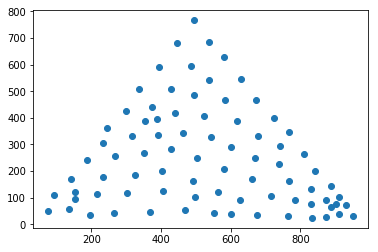

In [181]:
centroids = kmeans.cluster_centers_
for i in range(100):
    centroids = BalancedClustering_Method1(81, centroids, V)
plt.scatter(centroids[:,0],centroids[:,1])

Balanced Clustering Method 2
1. Loop through centroids set and assign [n/k] closest point to the current centroid using KD-Tree.
2. Delete those points and rebuild KD-Tree.
3. Repeat Step 1 and 2 until all points are assigned.
4. Iterate with updated centroids.

In [182]:
from sklearn.neighbors import KDTree

def BalancedClustering_Method2(k, cluster_centers, points):
    X = points.copy()
    centroids = np.zeros((k,2))
    n = int(points.shape[0]/k)
    for i in range(k):
        tree = KDTree(X)
        nearest_dist, nearest_ind = tree.query([cluster_centers[i,:]], k=n)
        centroids[i,:] = np.mean(X[nearest_ind[0]],axis=0)
        X = np.delete(X, nearest_ind[0], axis=0)
    return centroids

In [183]:
centroids = kmeans.cluster_centers_
for i in range(30):
    centroids = BalancedClustering_Method2(81, centroids, V)
plt.scatter(centroids[:,0],centroids[:,1])

KeyboardInterrupt: 

(81, 2)


(0, 1000)

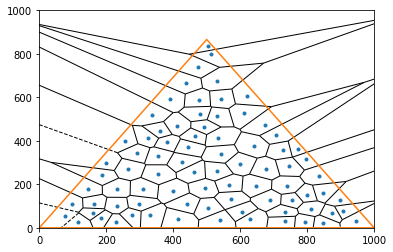

In [184]:
# Generate Voronoi with generator points = cluster centroids
# Note : Some generator points outside tringular boundary due to the error in coordinates.txt data
import scipy.spatial as spatial
print(centroids.shape)
vor = Voronoi(centroids)
voronoi_plot_2d(vor, show_vertices=False)
plt.plot([0,1000,500,0],[0,0,500*math.sqrt(3),0])
plt.xlim(0,1000)
plt.ylim(0,1000)

In [185]:
from shapely.geometry import Polygon

In [186]:
# Clip the Voronoi Diagram
# Run "conda install shapely -c conda-forge" on terminal first
# Method from StackOverflow
# Reference : https://stackoverflow.com/questions/36063533/clipping-a-voronoi-diagram-python
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

In [187]:
regions, vertices = voronoi_finite_polygons_2d(vor)

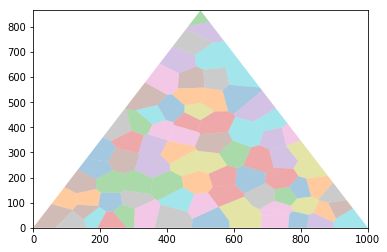

In [188]:
# Box the triangular boundary
box = Polygon([[0, 0], [1000, 0], [500, 500*math.sqrt(3)]])

# Final Output Districts
districts = []

# Colorize Districts
for region in regions:
    polygon = vertices[region]
    # Clipping polygon
    poly = Polygon(polygon)
    poly = poly.intersection(box)
    polygon = [p for p in poly.exterior.coords]
    districts.append(polygon)
    plt.fill(*zip(*polygon), alpha=0.4)

plt.xlim(0, 1000)
plt.ylim(0, 500*math.sqrt(3))
plt.show()

Delaunay Triangulation

333333


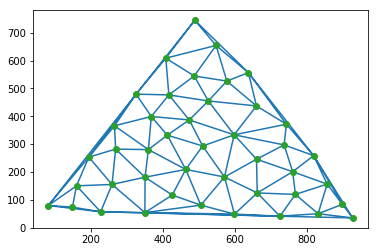

In [324]:
print(V.shape[0])
from scipy.spatial import Delaunay
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=43,random_state=0,batch_size=100,max_iter=10).fit(V)

points = np.zeros((43,2))
points[0:43,:] = kmeans.cluster_centers_.copy()
tri = Delaunay(points)
plt.triplot(points[:,0], points[:,1], tri.simplices.copy())
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

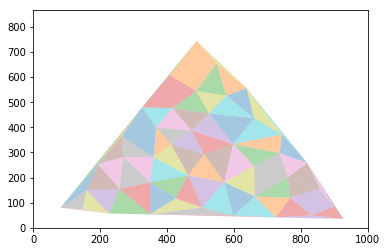

In [318]:
# Box the triangular boundary
box = Polygon([[0, 0], [1000, 0], [500, 500*math.sqrt(3)]])

# Final Output Districts
districts = []

# Colorize Districts
for region in tri.simplices:
    polygon = points[region]
    # Clipping polygon
    poly = Polygon(polygon)
    poly = poly.intersection(box)
    polygon = [p for p in poly.exterior.coords]
    districts.append(polygon)
    plt.fill(*zip(*polygon), alpha=0.4)

plt.xlim(0, 1000)
plt.ylim(0, 500*math.sqrt(3))
plt.show()

In [319]:
print(len(districts))

76


import matplotlib.path as mpltPath
from collections import Counter

regions = tri.simplices.copy()
cardinality = np.zeros((regions.shape[0],1))
visited = np.zeros((regions.shape[0],1))

idx = 0
for region in regions:
    polygon = points[region]
    path = mpltPath.Path(polygon)
    inside = np.ndarray.tolist(path.contains_points(V))
    num_pts = inside.count(True)
    cardinality[idx] = num_pts
    idx += 1

def findNeighborRegions(region, regions):
    neighbors = []
    for i in range(len(regions)):
        r = regions[i]
        intersection = list(set(region).intersection(set(r)))
        if len(intersection) == 3:
            continue
        if len(intersection) == 2:
            neighbors.append(i)
    return neighbors

districts = []

idx = 0
for region in regions:
    region_card = cardinality[idx] 
    visited[idx] = 1
    if region_card < (333333/81)*0.9:
        neighbors = findNeighborRegions(region, regions)
        for i in neighbors:
            
            if visited[i] == 1:
                continue
            
            neighbor_card = cardinality[i]
            if region_card + neighbor_card > (333333/81)*1.1:
                continue
            else:
                resultList= list(set(region) | set(regions[i]))
                districts.append(resultList)
                if  region_card + neighbor_card > (333333/81)*0.9:
                    visited[i] = 1
                break
    idx += 1

In [323]:
import matplotlib.path as mpltPath
from collections import Counter
for region in districts:
    path = mpltPath.Path(region)
    inside = np.ndarray.tolist(path.contains_points(V))
    num_pts = inside.count(True)
    print(num_pts)
    if num_pts < (333333/81)*0.9 or num_pts > (333333/81)*1.1:
        print(False)

2748
False
538
False
983
False
654
False
151
False
3412
False
392
False
5753
False
5210
False
3813
4390
3735
157
False
2999
False
3083
False
2904
False
5586
False
4110
891
False
680
False
3247
False
3596
False
3625
False
3412
False
3331
False
3842
3919
2605
False
2151
False
4900
False
2620
False
2765
False
3618
False
2478
False
1820
False
3400
False
2839
False
3196
False
2095
False
3471
False
3912
2810
False
3114
False
3453
False
4928
False
3426
False
3032
False
2994
False
3096
False
3376
False
5934
False
3351
False
3512
False
3582
False
4688
False
3750
2995
False
3868
2508
False
2727
False
2288
False
2152
False
2872
False
10055
False
7064
False
1751
False
962
False
3864
3125
False
4083
3947
3040
False
3042
False
4447
5908
False
3447
False


Result File Specification
 * First `numVoters + 1` lines are exactly the same with the map file.
 * Starting from `numVoters + 2` line, it contains a single integer `numDistricts`
   corresponding to the number of districts.
 * The following `numDistricts` lines describe the shape of districts.
    * Each line starts with an integer `p`, followed by `2p` float numbers describes the
      coordinates of `p` vertices of this district (a polygon).
      The `p` vertices shall be given in order, either clockwise or counter-clockwise.

In [193]:
output = []
for i in range(len(districts)):
    line = []
    line.append(len(districts[i]))
    for j in range(len(districts[i])):
        line.append(districts[i][j][0])
        line.append(districts[i][j][1])
    output.append(line)

In [194]:
with open('result_2_parties.txt', 'w') as f:
    for line in output:
        for item in line:
            f.write('%s ' % item)
        f.write('\n')
f.close()

In [195]:
content = []
with open('twoParties.map', 'r+') as f:
    content = f.readlines()
f.close()
# you may also want to remove whitespace characters like `\n` at the end of each line
content = content[0:len(content)-1]
content.append('81')

output = []
for i in range(len(districts)):
    line = []
    line.append(len(districts[i]))
    for j in range(len(districts[i])):
        line.append(districts[i][j][0])
        line.append(districts[i][j][1])
    output.append(line)

with open('result.txt', 'w') as f:
    f.writelines(content)
    f.write('\n')
    for line in output:
        for item in line:
            f.write('%s ' % item)
        f.write('\n')
f.close()